In [ ]:
import os
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# Path to LensCorrection dataset
DATA_ROOT = Path("/Users/darshanrao/Developer/auto_hdr_rewamp/lens-correction-train-cleaned")

In [3]:




def get_distorted_paths(data_root: Path) -> list[tuple[Path, Path]]:
    """Find all (distorted, corrected) pairs. Returns [(original_path, generated_path), ...]"""
    pairs = []
    for f in data_root.glob("*_original.jpg"):
        generated = f.parent / f.name.replace("_original.jpg", "_generated.jpg")
        if generated.exists():
            pairs.append((f, generated))
    return pairs

# Get pairs
pairs = get_distorted_paths(DATA_ROOT)
print(f"Found {len(pairs)} distorted↔corrected pairs")

# IPa: Load a distorted image
def load_distorted(pair_idx: int = 0) -> np.ndarray:
    """Load distorted image (original) as numpy array (H, W, 3) RGB"""
    orig_path, _ = pairs[pair_idx]
    img = np.array(Image.open(orig_path).convert("RGB"))
    return img

# Example
img_distorted = load_distorted(0)
print(f"Distorted shape: {img_distorted.shape}, dtype: {img_distorted.dtype}")

Found 23118 distorted↔corrected pairs
Distorted shape: (1364, 2048, 3), dtype: uint8


In [4]:
# Build pairs: original (distorted) ↔ generated (corrected)
originals = sorted(DATA_ROOT.glob("*_original.jpg"))
generated = [p.parent / p.name.replace("_original.jpg", "_generated.jpg") for p in originals]
pairs = [(o, g) for o, g in zip(originals, generated) if g.exists()]

distorted_paths = [p[0] for p in pairs]
corrected_paths = [p[1] for p in pairs]

# ── 1.1 Basic counts ──
print(f"Original (distorted) images:  {len(originals)}")
print(f"Generated (corrected) images: {len(corrected_paths)}")
print(f"Pairs matched:               {len(pairs)} (both exist)")
if len(originals) != len(pairs):
    print(f"  → {len(originals) - len(pairs)} originals have no matching generated")

# ── 1.2 File formats ──
ext_d = set(p.suffix for p in distorted_paths)
ext_c = set(p.suffix for p in corrected_paths)
print(f"Distorted formats: {ext_d}")
print(f"Corrected formats: {ext_c}")

# ── 1.3 Pairing sanity (first 5) ──
print("\nSample pair stems (distorted ←→ corrected):")
for d, c in pairs[:5]:
    base_d = d.stem.replace("_original", "")
    base_c = c.stem.replace("_generated", "")
    match = "✓" if base_d == base_c else "✗"
    print(f"  {match}  {d.name[:50]:50}  ←→  {c.name[:50]}")



Original (distorted) images:  23118
Generated (corrected) images: 23118
Pairs matched:               23118 (both exist)
Distorted formats: {'.jpg'}
Corrected formats: {'.jpg'}

Sample pair stems (distorted ←→ corrected):
  ✓  0002be68-04ec-442b-9d26-418d9c229b33_g0_original.j  ←→  0002be68-04ec-442b-9d26-418d9c229b33_g0_generated.
  ✓  0002be68-04ec-442b-9d26-418d9c229b33_g13_original.  ←→  0002be68-04ec-442b-9d26-418d9c229b33_g13_generated
  ✓  0002be68-04ec-442b-9d26-418d9c229b33_g8_original.j  ←→  0002be68-04ec-442b-9d26-418d9c229b33_g8_generated.
  ✓  0002be68-04ec-442b-9d26-418d9c229b33_g9_original.j  ←→  0002be68-04ec-442b-9d26-418d9c229b33_g9_generated.
  ✓  00480c6b-6232-4205-a25c-9dff34ac6337_g5_original.j  ←→  00480c6b-6232-4205-a25c-9dff34ac6337_g5_generated.


In [11]:
sizes_dist = {}
sizes_corr = {}
corrupted_dist = []
corrupted_corr = []

for path in distorted_paths[:1000]:
    try:
        img = cv2.imread(str(path))
        if img is None:
            corrupted_dist.append(path)
            continue
        h, w = img.shape[:2]
        sizes_dist[(h, w)] = sizes_dist.get((h, w), 0) + 1
    except Exception:
        corrupted_dist.append(path)

for path in corrected_paths[:1000]:
    try:
        img = cv2.imread(str(path))
        if img is None:
            corrupted_corr.append(path)
            continue
        h, w = img.shape[:2]
        sizes_corr[(h, w)] = sizes_corr.get((h, w), 0) + 1
    except Exception:
        corrupted_corr.append(path)

total = len(distorted_paths)
print("Distorted — size distribution:")
for (h, w), count in sorted(sizes_dist.items(), key=lambda x: -x[1]):
    print(f"  {w}×{h}: {count} images ({100*count/total:.1f}%)")

print("\nCorrected — size distribution:")
for (h, w), count in sorted(sizes_corr.items(), key=lambda x: -x[1]):
    print(f"  {w}×{h}: {count} images ({100*count/total:.1f}%)")

print(f"\nCorrupted distorted: {len(corrupted_dist)}")
print(f"Corrupted corrected: {len(corrupted_corr)}")
if corrupted_dist or corrupted_corr:
    for p in (corrupted_dist[:3] + corrupted_corr[:3]):
        print(f"  {p.name}")

Distorted — size distribution:
  2048×1367: 444 images (1.9%)
  2048×1366: 186 images (0.8%)
  2048×1365: 94 images (0.4%)
  2048×1364: 92 images (0.4%)
  2048×1363: 56 images (0.2%)
  2048×1369: 47 images (0.2%)
  2048×1360: 22 images (0.1%)
  2048×1362: 13 images (0.1%)
  2048×1357: 11 images (0.0%)
  2048×1368: 9 images (0.0%)
  1367×2048: 6 images (0.0%)
  2048×1538: 5 images (0.0%)
  2048×1342: 4 images (0.0%)
  1366×2048: 3 images (0.0%)
  2048×1371: 3 images (0.0%)
  2048×1353: 1 images (0.0%)
  1364×2048: 1 images (0.0%)
  2048×1359: 1 images (0.0%)
  1360×2048: 1 images (0.0%)
  2048×1534: 1 images (0.0%)

Corrected — size distribution:
  2048×1367: 444 images (1.9%)
  2048×1366: 186 images (0.8%)
  2048×1365: 94 images (0.4%)
  2048×1364: 92 images (0.4%)
  2048×1363: 56 images (0.2%)
  2048×1369: 47 images (0.2%)
  2048×1360: 22 images (0.1%)
  2048×1362: 13 images (0.1%)
  2048×1357: 11 images (0.0%)
  2048×1368: 9 images (0.0%)
  1367×2048: 6 images (0.0%)
  2048×1538: 5 i

In [10]:
# Pairs should have same (h, w)
mismatch_dims = []
for d_path, c_path in pairs[:23000]:  # or use full pairs
    try:
        hd, wd = cv2.imread(str(d_path)).shape[:2]
        hc, wc = cv2.imread(str(c_path)).shape[:2]
        if (hd, wd) != (hc, wc):
            mismatch_dims.append((d_path.name, (wd, hd), (wc, hc)))
    except:
        pass
print(f"Pairs with different dims (sample of 1000): {len(mismatch_dims)}")
if mismatch_dims:
    for name, d_size, c_size in mismatch_dims[:3]:
        print(f"  {name}: distorted {d_size} vs corrected {c_size}")

Pairs with different dims (sample of 1000): 0


In [14]:
import random
sample_pairs = list(zip(distorted_paths, corrected_paths))
random.seed(42)  # reproducibility
sample_pairs = random.sample(sample_pairs, min(1000, len(sample_pairs)))

In [16]:
# Pre-process: keep only landscape pairs (width >= height, so width=2048)
# Portrait images have height=2048, width=smaller → exclude or would need rotation
from PIL import Image

def is_landscape(path):
    with Image.open(path) as im:
        w, h = im.size
    return w >= h

n_before = len(sample_pairs)
sample_pairs = [(d, c) for d, c in sample_pairs if is_landscape(d)]
n_after = len(sample_pairs)
print(f"Landscape pairs: {n_after} (filtered {n_before - n_after} portrait)")

Landscape pairs: 994 (filtered 6 portrait)


In [18]:
import pandas as pd
import random
from tqdm import tqdm
from PIL import Image

# Sample 1,000 random pairs for fast exploration
sample_pairs = list(zip(distorted_paths, corrected_paths))
random.seed(42)
sample_pairs = random.sample(sample_pairs, min(1000, len(sample_pairs)))

# Pre-process: keep only landscape (width >= height)
def is_landscape(path):
    with Image.open(path) as im:
        w, h = im.size
    return w >= h

sample_pairs = [(d, c) for d, c in sample_pairs if is_landscape(d)]

records = []

for dist_p, corr_p in tqdm(sample_pairs):
    dist = cv2.imread(str(dist_p))
    corr = cv2.imread(str(corr_p))

    if dist is None or corr is None:
        continue

    dh, dw = dist.shape[:2]
    ch, cw = corr.shape[:2]

    if (dh, dw) != (ch, cw):
        continue

    # Compute center vs edge pixel difference
    diff = cv2.absdiff(dist, corr).mean(axis=2)

    # Center 10% of image
    cy_s, cy_e = int(dh * 0.45), int(dh * 0.55)
    cx_s, cx_e = int(dw * 0.45), int(dw * 0.55)
    center_diff = diff[cy_s:cy_e, cx_s:cx_e].mean()

    # Outer 20% of image
    edge_diff = np.concatenate([
        diff[: int(dh * 0.2), :].ravel(),
        diff[-int(dh * 0.2) :, :].ravel(),
        diff[:, : int(dw * 0.2)].ravel(),
        diff[:, -int(dw * 0.2) :].ravel(),
    ]).mean()

    records.append({
        "image_id": dist_p.stem,
        "width": dw,
        "height": dh,
        "aspect_ratio": dw / dh,
        "center_diff": center_diff,
        "edge_diff": edge_diff,
        "ratio": edge_diff / (center_diff + 1e-6),
        "overall_diff": diff.mean(),
        "size_match": (dh == ch) and (dw == cw),
    })

df = pd.DataFrame(records)

print("=" * 50)
print("KEY FINDINGS")
print("=" * 50)

print(f"\n1. ALL pairs same size: {df['size_match'].all()}")

print(f"\n2. Aspect ratio distribution:")
print(f"   Min:    {df['aspect_ratio'].min():.4f}")
print(f"   Max:    {df['aspect_ratio'].max():.4f}")
print(f"   Mean:   {df['aspect_ratio'].mean():.4f}")
print(f"   Std:    {df['aspect_ratio'].std():.4f}")

print(f"\n3. Center vs Edge difference (confirms barrel):")
print(f"   Center diff mean: {df['center_diff'].mean():.3f}")
print(f"   Edge diff mean:   {df['edge_diff'].mean():.3f}")
print(f"   Ratio mean:       {df['ratio'].mean():.2f}x")
print(f"   Ratio std:        {df['ratio'].std():.2f}")

print(f"\n4. Distortion magnitude spread:")
print(f"   Min overall diff:    {df['overall_diff'].min():.3f}")
print(f"   Max overall diff:    {df['overall_diff'].max():.3f}")
print(f"   Mean overall diff:   {df['overall_diff'].mean():.3f}")

print(f"\n5. Height variation:")
print(f"   Unique heights: {df['height'].nunique()}")
print(f"   Height range:   {df['height'].min()} → {df['height'].max()}")
print(f"   This means {df['height'].nunique()} different camera aspect ratios")

100%|██████████| 994/994 [01:03<00:00, 15.69it/s]

KEY FINDINGS

1. ALL pairs same size: True

2. Aspect ratio distribution:
   Min:    1.3351
   Max:    1.5261
   Mean:   1.4993
   Std:    0.0079

3. Center vs Edge difference (confirms barrel):
   Center diff mean: 5.064
   Edge diff mean:   6.781
   Ratio mean:       2.51x
   Ratio std:        2.35

4. Distortion magnitude spread:
   Min overall diff:    0.000
   Max overall diff:    30.710
   Mean overall diff:   6.770

5. Height variation:
   Unique heights: 19
   Height range:   1342 → 1534
   This means 19 different camera aspect ratios


In [2]:
def load_corrected(pair_idx: int = 0) -> np.ndarray:
    """Load corrected image (generated) as numpy array (H, W, 3) RGB"""
    _, gen_path = pairs[pair_idx]
    img = np.array(Image.open(gen_path).convert("RGB"))
    return img

def load_pair(pair_idx: int) -> tuple[np.ndarray, np.ndarray]:
    """Load (distorted, corrected) as numpy arrays"""
    return load_distorted(pair_idx), load_corrected(pair_idx)

# IPb example
img_corrected = load_corrected(0)
print(f"Corrected shape: {img_corrected.shape}")

Corrected shape: (1364, 2048, 3)


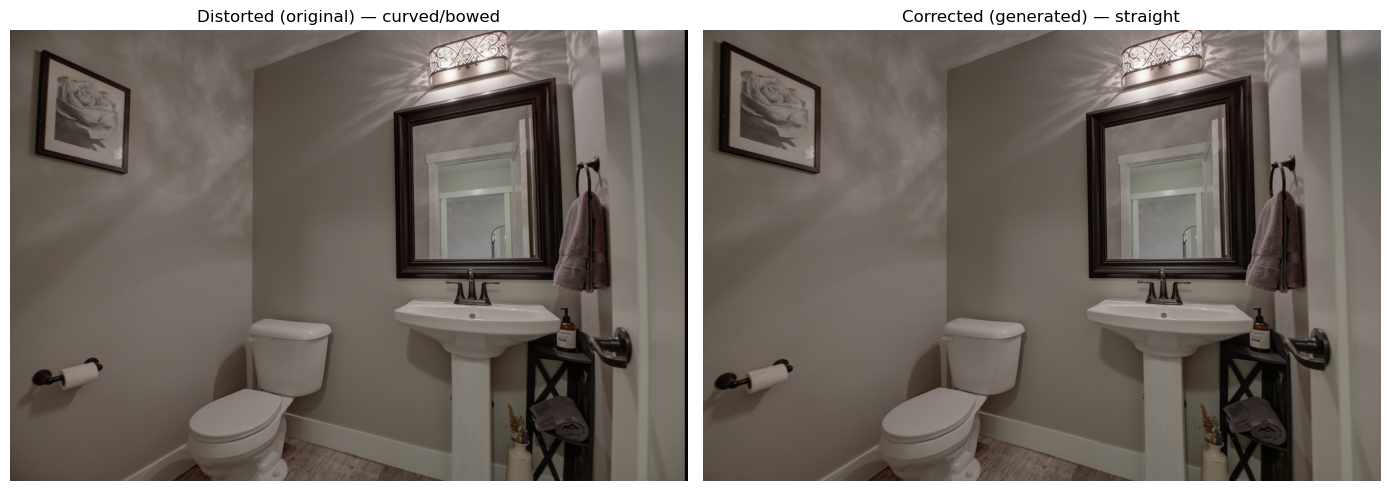

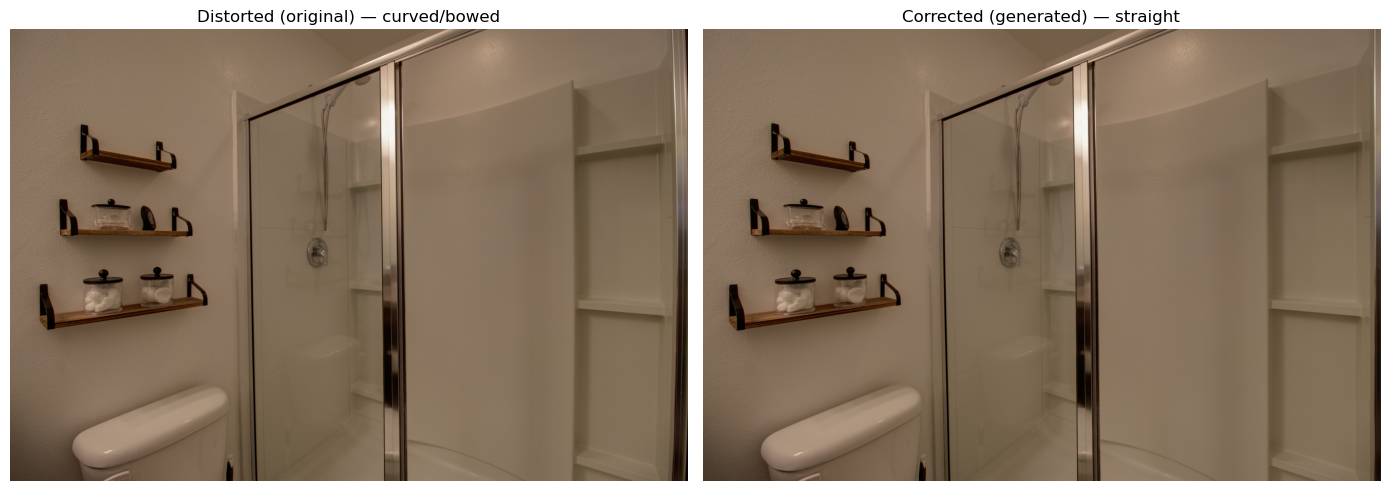

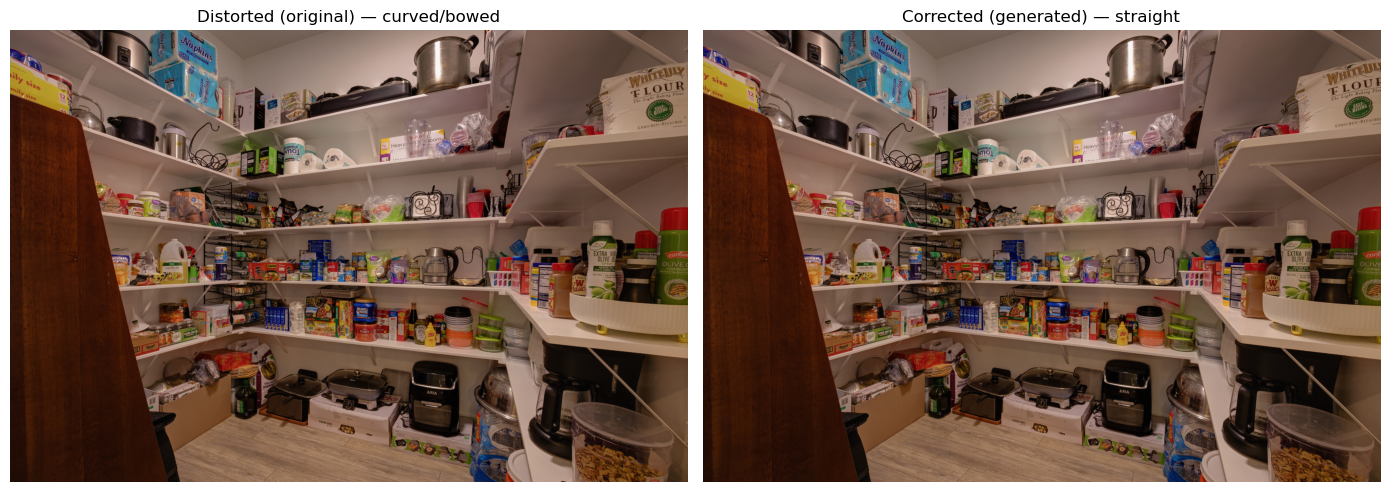

In [3]:
import matplotlib.pyplot as plt

def show_pair(pair_idx: int, figsize=(14, 6)):
    distorted, corrected = load_pair(pair_idx)
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].imshow(distorted)
    axes[0].set_title("Distorted (original) — curved/bowed")
    axes[0].axis("off")
    axes[1].imshow(corrected)
    axes[1].set_title("Corrected (generated) — straight")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

# View a few pairs
for i in [0, 100, 500]:  # adjust indices to sample different images
    show_pair(i)

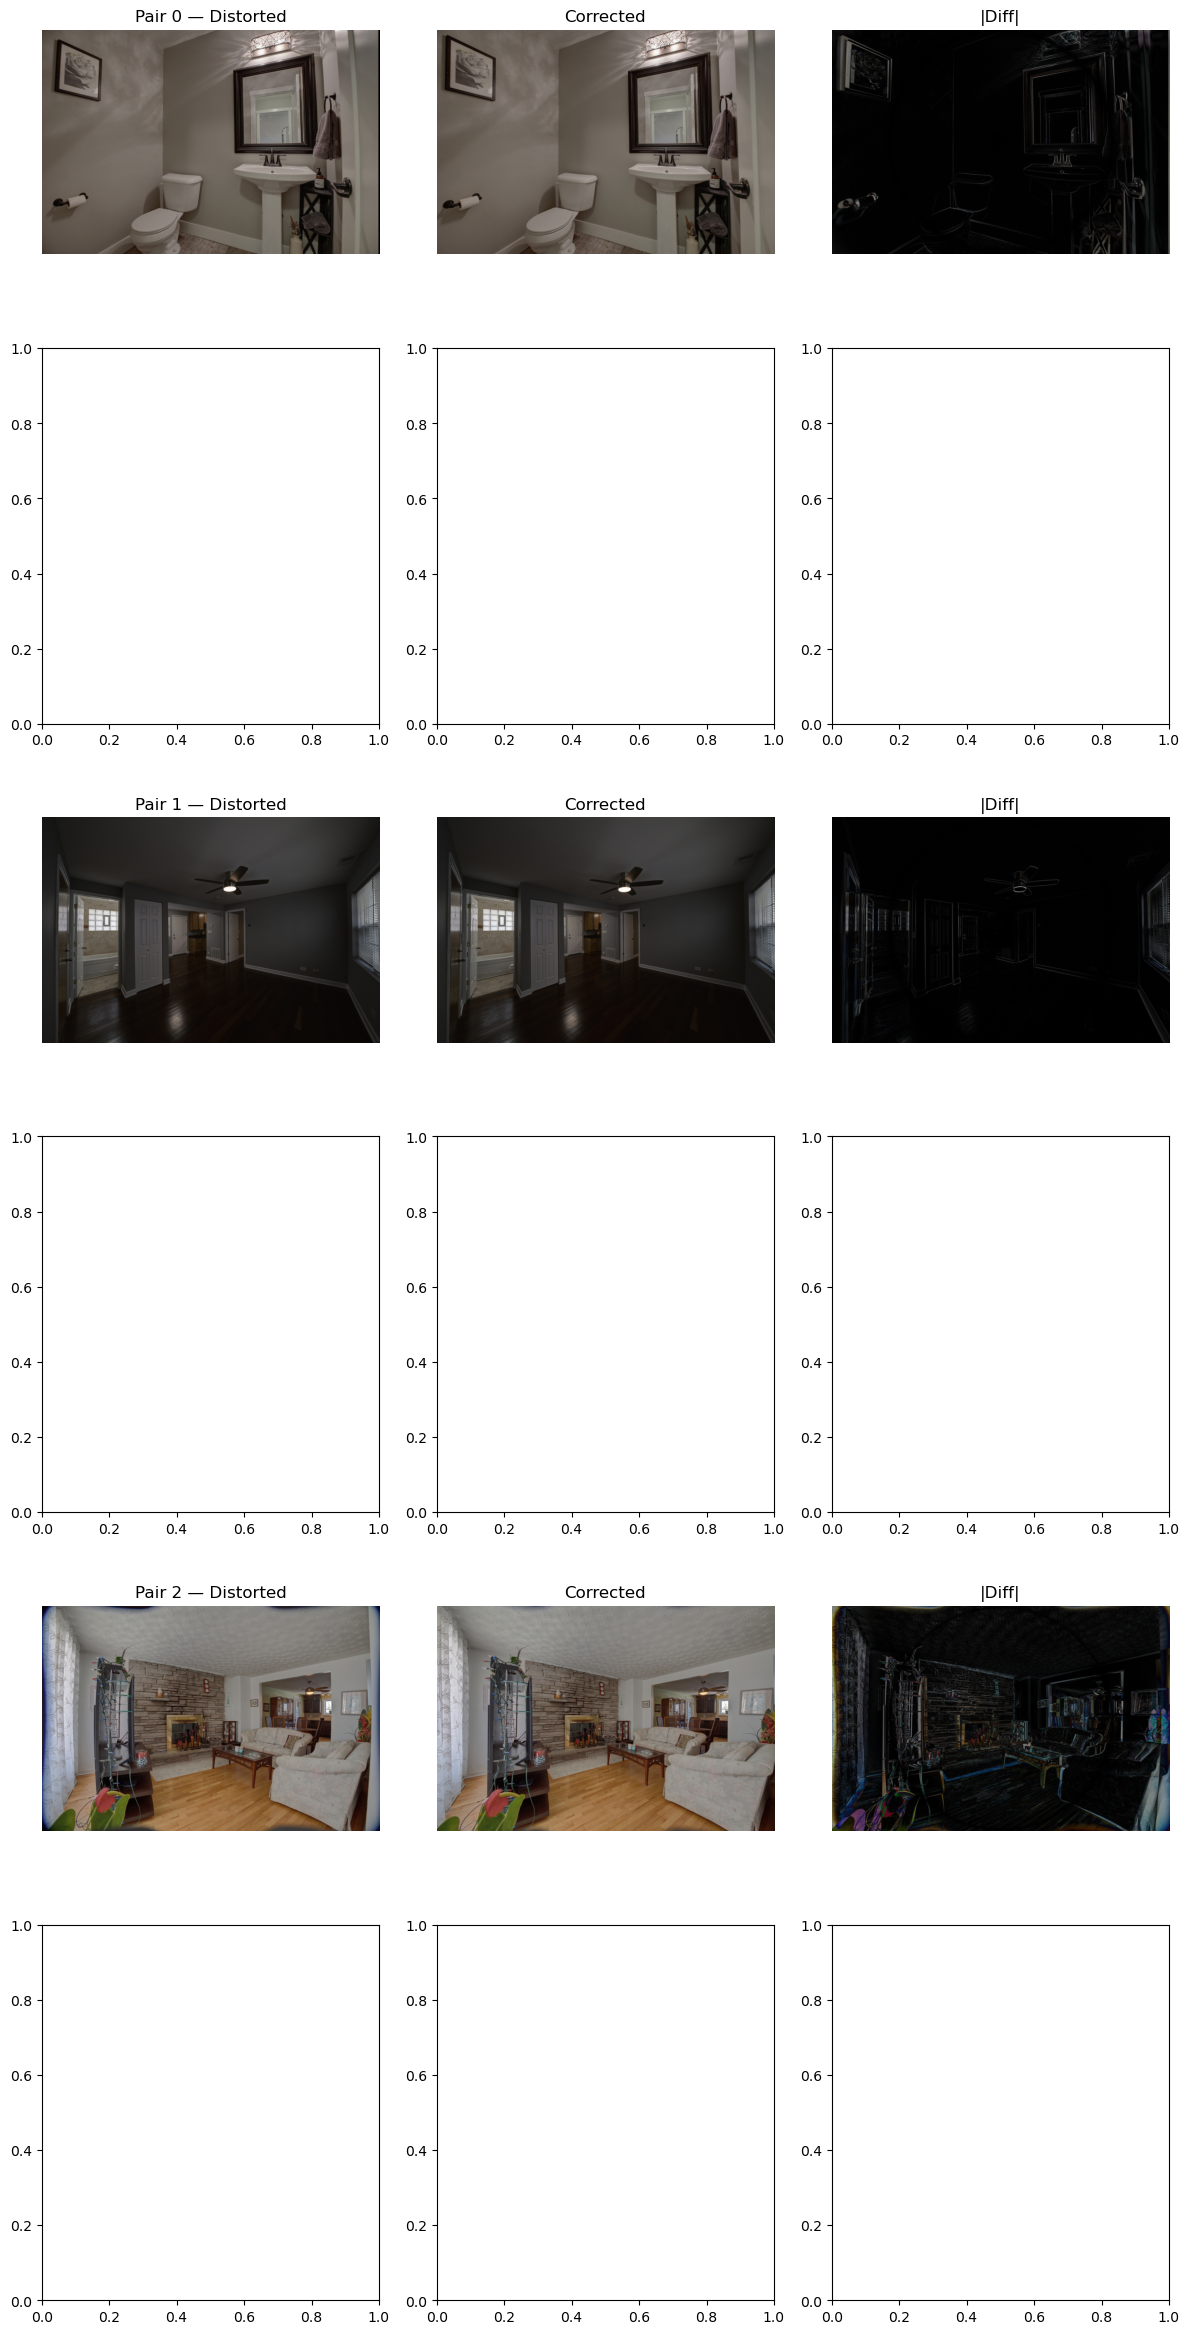

In [4]:
def show_sample_grid(pair_indices: list[int], cols: int = 3):
    n = len(pair_indices)
    rows = n * 2  # each pair = 2 rows (distorted, corrected)
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    for r, idx in enumerate(pair_indices):
        d, c = load_pair(idx)
        axes[r * 2, 0].imshow(d)
        axes[r * 2, 0].set_title(f"Pair {idx} — Distorted")
        axes[r * 2, 0].axis("off")
        axes[r * 2, 1].imshow(c)
        axes[r * 2, 1].set_title("Corrected")
        axes[r * 2, 1].axis("off")
        # Optional: difference
        axes[r * 2, 2].imshow(np.abs(d.astype(float) - c.astype(float)).astype(np.uint8))
        axes[r * 2, 2].set_title("|Diff|")
        axes[r * 2, 2].axis("off")
    plt.tight_layout()
    plt.show()

show_sample_grid([0, 1, 2])

In [19]:
# ── Verification: height + distortion magnitude, tight center, single pixel ──
from scipy.stats import pearsonr

records_verify = []

for dist_p, corr_p in tqdm(sample_pairs):
    dist = cv2.imread(str(dist_p))
    corr = cv2.imread(str(corr_p))
    if dist is None or corr is None:
        continue

    dh, dw = dist.shape[:2]

    if dh > dw:
        continue

    diff = cv2.absdiff(dist, corr).mean(axis=2)

    cy_s = int(dh * 0.49)
    cy_e = int(dh * 0.51)
    cx_s = int(dw * 0.49)
    cx_e = int(dw * 0.51)
    tight_center_diff = diff[cy_s:cy_e, cx_s:cx_e].mean()
    single_px_diff = diff[dh // 2, dw // 2]

    edge_mask = np.zeros((dh, dw), dtype=bool)
    edge_mask[: int(dh * 0.2), :] = True
    edge_mask[-int(dh * 0.2) :, :] = True
    edge_diff = diff[edge_mask].mean()

    overall = diff.mean()

    records_verify.append({
        "image_id": dist_p.stem,
        "height": dh,
        "width": dw,
        "aspect_ratio": dw / dh,
        "overall_diff": overall,
        "tight_center": tight_center_diff,
        "single_px": single_px_diff,
        "edge_diff": edge_diff,
        "edge_ratio": edge_diff / (tight_center_diff + 1e-6),
    })

df_verify = pd.DataFrame(records_verify)

corr_coef, p_value = pearsonr(df_verify["height"], df_verify["overall_diff"])
print("Correlation: height vs overall_diff")
print(f"  Pearson r:  {corr_coef:.4f}")
print(f"  p-value:    {p_value:.6f}")
print(f"  {'STRONG' if abs(corr_coef) > 0.7 else 'MODERATE' if abs(corr_coef) > 0.4 else 'WEAK'} correlation")

print("\nTight center (±1% zone):")
print(f"  Mean diff:   {df_verify['tight_center'].mean():.4f}")
print(f"  Median diff: {df_verify['tight_center'].median():.4f}")

print("\nSingle center pixel:")
print(f"  Mean diff:   {df_verify['single_px'].mean():.4f}")
print(f"  Median diff: {df_verify['single_px'].median():.4f}")
print(f"  % near zero (<1.0): {(df_verify['single_px'] < 1.0).mean()*100:.1f}%")
print(f"  % near zero (<2.0): {(df_verify['single_px'] < 2.0).mean()*100:.1f}%")

print("\nHeight buckets vs mean distortion:")
df_verify["height_bucket"] = pd.cut(df_verify["height"], bins=10)
print(df_verify.groupby("height_bucket")["overall_diff"].mean().to_string())

100%|██████████| 994/994 [00:59<00:00, 16.71it/s]


Correlation: height vs overall_diff
  Pearson r:  0.0341
  p-value:    0.282730
  WEAK correlation

Tight center (±1% zone):
  Mean diff:   1.9772
  Median diff: 1.1915

Single center pixel:
  Mean diff:   0.9054
  Median diff: 1.0000
  % near zero (<1.0): 41.0%
  % near zero (<2.0): 89.3%

Height buckets vs mean distortion:
height_bucket
(1341.808, 1361.2]    6.960312
(1361.2, 1380.4]      6.755474
(1380.4, 1399.6]           NaN
(1399.6, 1418.8]           NaN
(1418.8, 1438.0]           NaN
(1438.0, 1457.2]           NaN
(1457.2, 1476.4]           NaN
(1476.4, 1495.6]           NaN
(1495.6, 1514.8]           NaN
(1514.8, 1534.0]      7.558365


/var/folders/64/glschqjx3sn28wyvf5wwcx2r0000gn/T/ipykernel_15329/3787171109.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_verify.groupby("height_bucket")["overall_diff"].mean().to_string())


In [20]:
# Quick JPEG test
sample_path = distorted_paths[0]
img_pil = Image.open(sample_path)
print(f"Format: {img_pil.format}")
print(f"Mode:   {img_pil.mode}")

if img_pil.format == "JPEG":
    print("Files are JPEG → center diff of ~5 is likely compression noise")
    print("This is NOT a problem — it means geometry is clean")

Format: JPEG
Mode:   RGB
Files are JPEG → center diff of ~5 is likely compression noise
This is NOT a problem — it means geometry is clean


Main group  (h=1342-1380): 992 images
Tall group  (h=1515-1534): 2 images


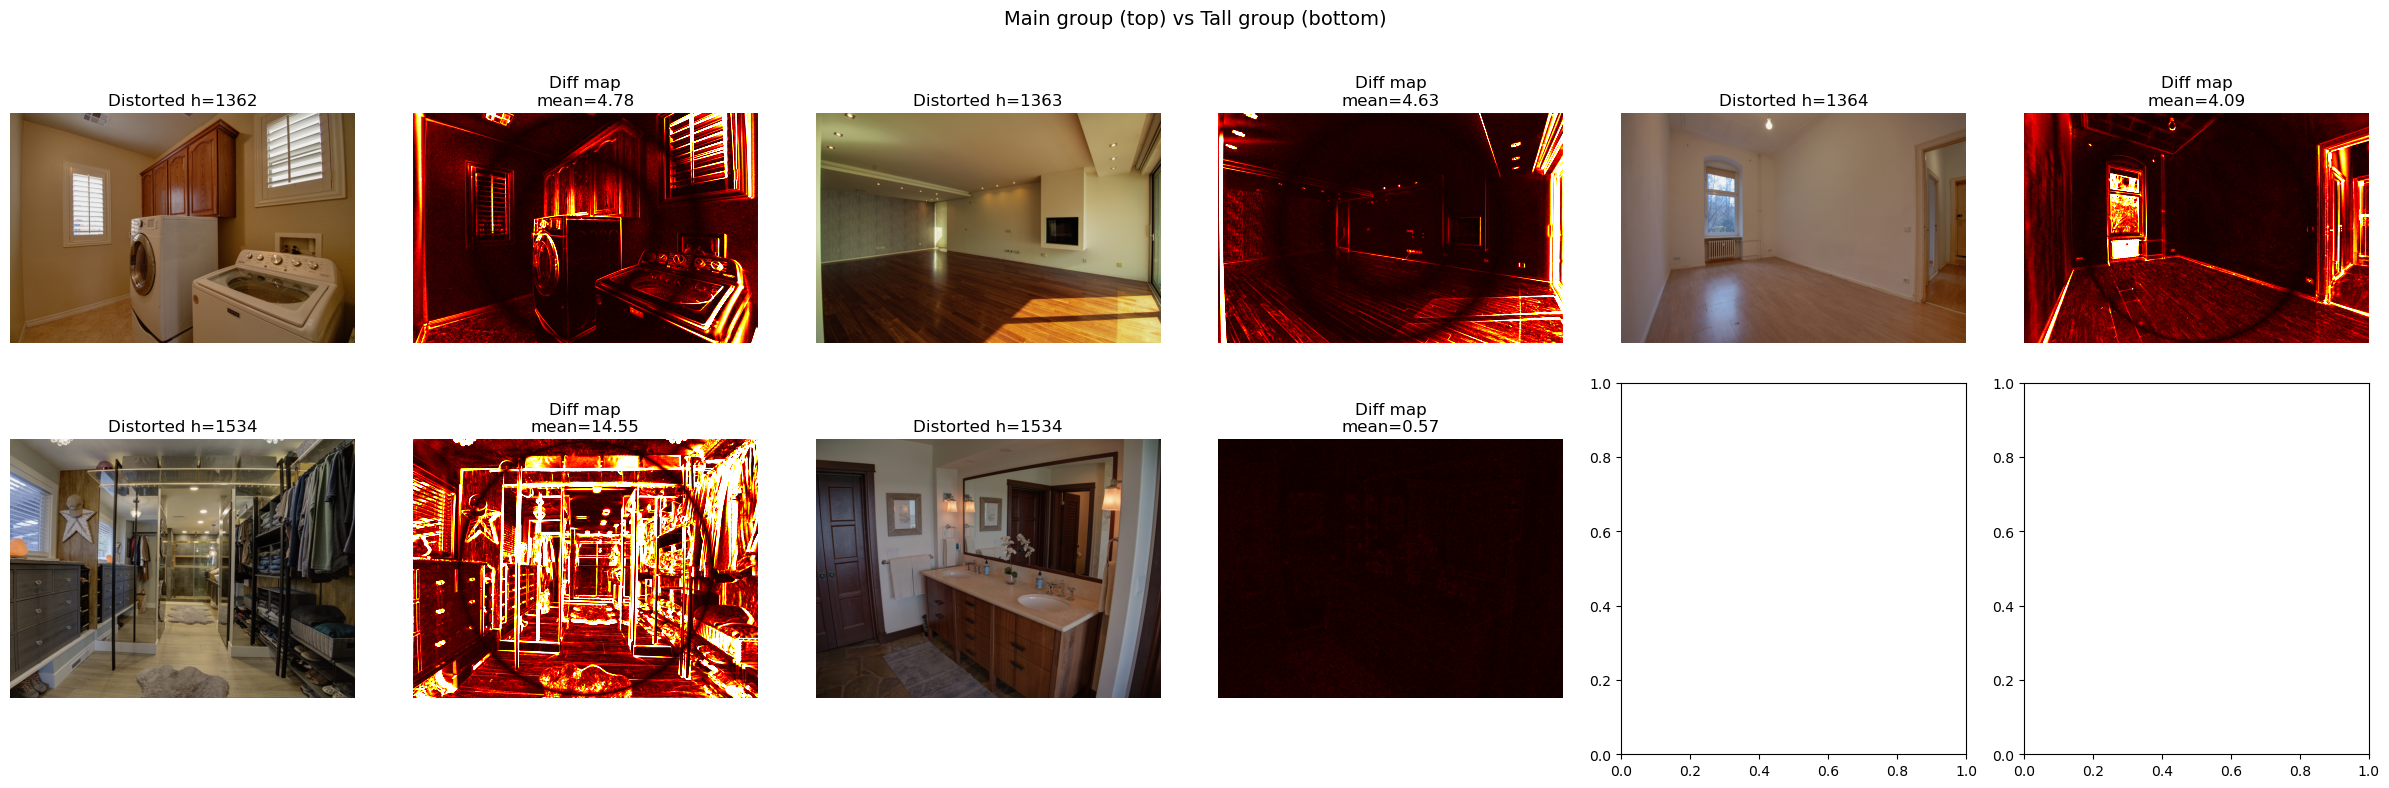


Main group distortion:  mean=6.768  std=3.287
Tall group distortion:  mean=7.558  std=6.993


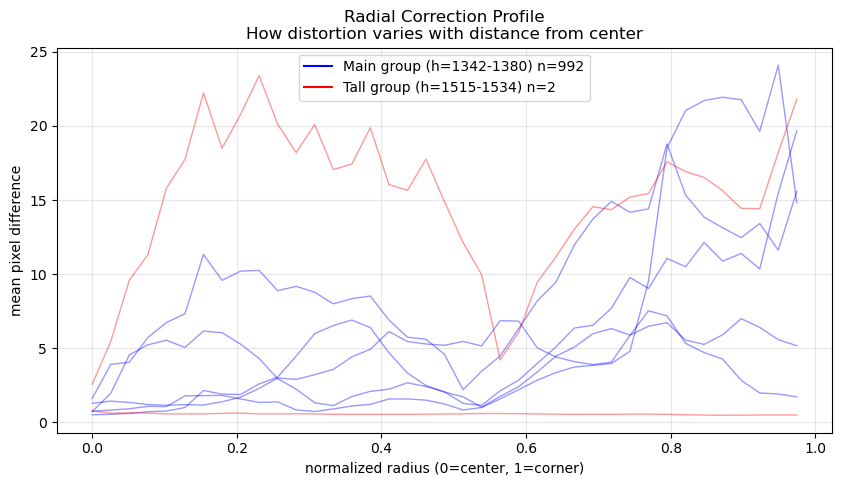

In [26]:
# Bimodal Height Split — Main (h=1342-1380) vs Tall (h=1515-1534)
# Uses same sample_pairs (random + landscape-filtered)
group_main = []
group_tall = []

for dist_p, corr_p in sample_pairs:
    dist = cv2.imread(str(dist_p))
    if dist is None:
        continue
    h, w = dist.shape[:2]
    if h > w:
        continue
    if 1342 <= h <= 1380:
        group_main.append((dist_p, corr_p, h))
    elif 1515 <= h <= 1534:
        group_tall.append((dist_p, corr_p, h))

print(f"Main group  (h=1342-1380): {len(group_main)} images")
print(f"Tall group  (h=1515-1534): {len(group_tall)} images")

# Side-by-side: 3 from each group
fig, axes = plt.subplots(2, 6, figsize=(24, 8))
fig.suptitle("Main group (top) vs Tall group (bottom)", fontsize=14)

for i, (dist_p, corr_p, h) in enumerate(group_main[:3]):
    dist = cv2.imread(str(dist_p))
    corr = cv2.imread(str(corr_p))
    diff = cv2.absdiff(dist, corr).mean(axis=2)

    axes[0, i * 2].imshow(cv2.cvtColor(dist, cv2.COLOR_BGR2RGB))
    axes[0, i * 2].set_title(f"Distorted h={h}")
    axes[0, i * 2].axis("off")

    axes[0, i * 2 + 1].imshow(diff, cmap="hot", vmin=0, vmax=30)
    axes[0, i * 2 + 1].set_title(f"Diff map\nmean={diff.mean():.2f}")
    axes[0, i * 2 + 1].axis("off")

for i, (dist_p, corr_p, h) in enumerate(group_tall[:3]):
    dist = cv2.imread(str(dist_p))
    corr = cv2.imread(str(corr_p))
    diff = cv2.absdiff(dist, corr).mean(axis=2)

    axes[1, i * 2].imshow(cv2.cvtColor(dist, cv2.COLOR_BGR2RGB))
    axes[1, i * 2].set_title(f"Distorted h={h}")
    axes[1, i * 2].axis("off")

    axes[1, i * 2 + 1].imshow(diff, cmap="hot", vmin=0, vmax=30)
    axes[1, i * 2 + 1].set_title(f"Diff map\nmean={diff.mean():.2f}")
    axes[1, i * 2 + 1].axis("off")

plt.tight_layout()
plt.savefig("two_groups_comparison.png", dpi=150)
plt.show()

# Distortion magnitude comparison
main_diffs = []
tall_diffs = []

for dist_p, corr_p, h in group_main:
    dist = cv2.imread(str(dist_p))
    corr = cv2.imread(str(corr_p))
    if dist is None or corr is None:
        continue
    main_diffs.append(cv2.absdiff(dist, corr).mean())

for dist_p, corr_p, h in group_tall:
    dist = cv2.imread(str(dist_p))
    corr = cv2.imread(str(corr_p))
    if dist is None or corr is None:
        continue
    tall_diffs.append(cv2.absdiff(dist, corr).mean())

print(f"\nMain group distortion:  mean={np.mean(main_diffs):.3f}  std={np.std(main_diffs):.3f}")
print(f"Tall group distortion:  mean={np.mean(tall_diffs):.3f}  std={np.std(tall_diffs):.3f}")

# Radial profile comparison
def radial_profile(dist_path, corr_path):
    dist = cv2.imread(str(dist_path))
    corr = cv2.imread(str(corr_path))
    diff = cv2.absdiff(dist, corr).mean(axis=2)
    h, w = diff.shape
    cx, cy = w // 2, h // 2
    y_grid, x_grid = np.mgrid[0:h, 0:w]
    r = np.sqrt((x_grid - cx) ** 2 + (y_grid - cy) ** 2)
    r_norm = r / r.max()
    bins = np.linspace(0, 1, 40)
    means = []
    for i in range(len(bins) - 1):
        mask = (r_norm >= bins[i]) & (r_norm < bins[i + 1])
        means.append(diff[mask].mean() if mask.sum() > 0 else 0)
    return bins[:-1], means

plt.figure(figsize=(10, 5))

for dist_p, corr_p, h in group_main[:5]:
    radii, means = radial_profile(dist_p, corr_p)
    plt.plot(radii, means, alpha=0.4, color="blue", linewidth=1)

for dist_p, corr_p, h in group_tall[:5]:
    radii, means = radial_profile(dist_p, corr_p)
    plt.plot(radii, means, alpha=0.4, color="red", linewidth=1)

plt.plot([], [], color="blue", label=f"Main group (h=1342-1380) n={len(group_main)}")
plt.plot([], [], color="red", label=f"Tall group (h=1515-1534) n={len(group_tall)}")
plt.xlabel("normalized radius (0=center, 1=corner)")
plt.ylabel("mean pixel difference")
plt.title("Radial Correction Profile\nHow distortion varies with distance from center")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("radial_profiles.png", dpi=150)
plt.show()

21233it [11:53, 29.76it/s]


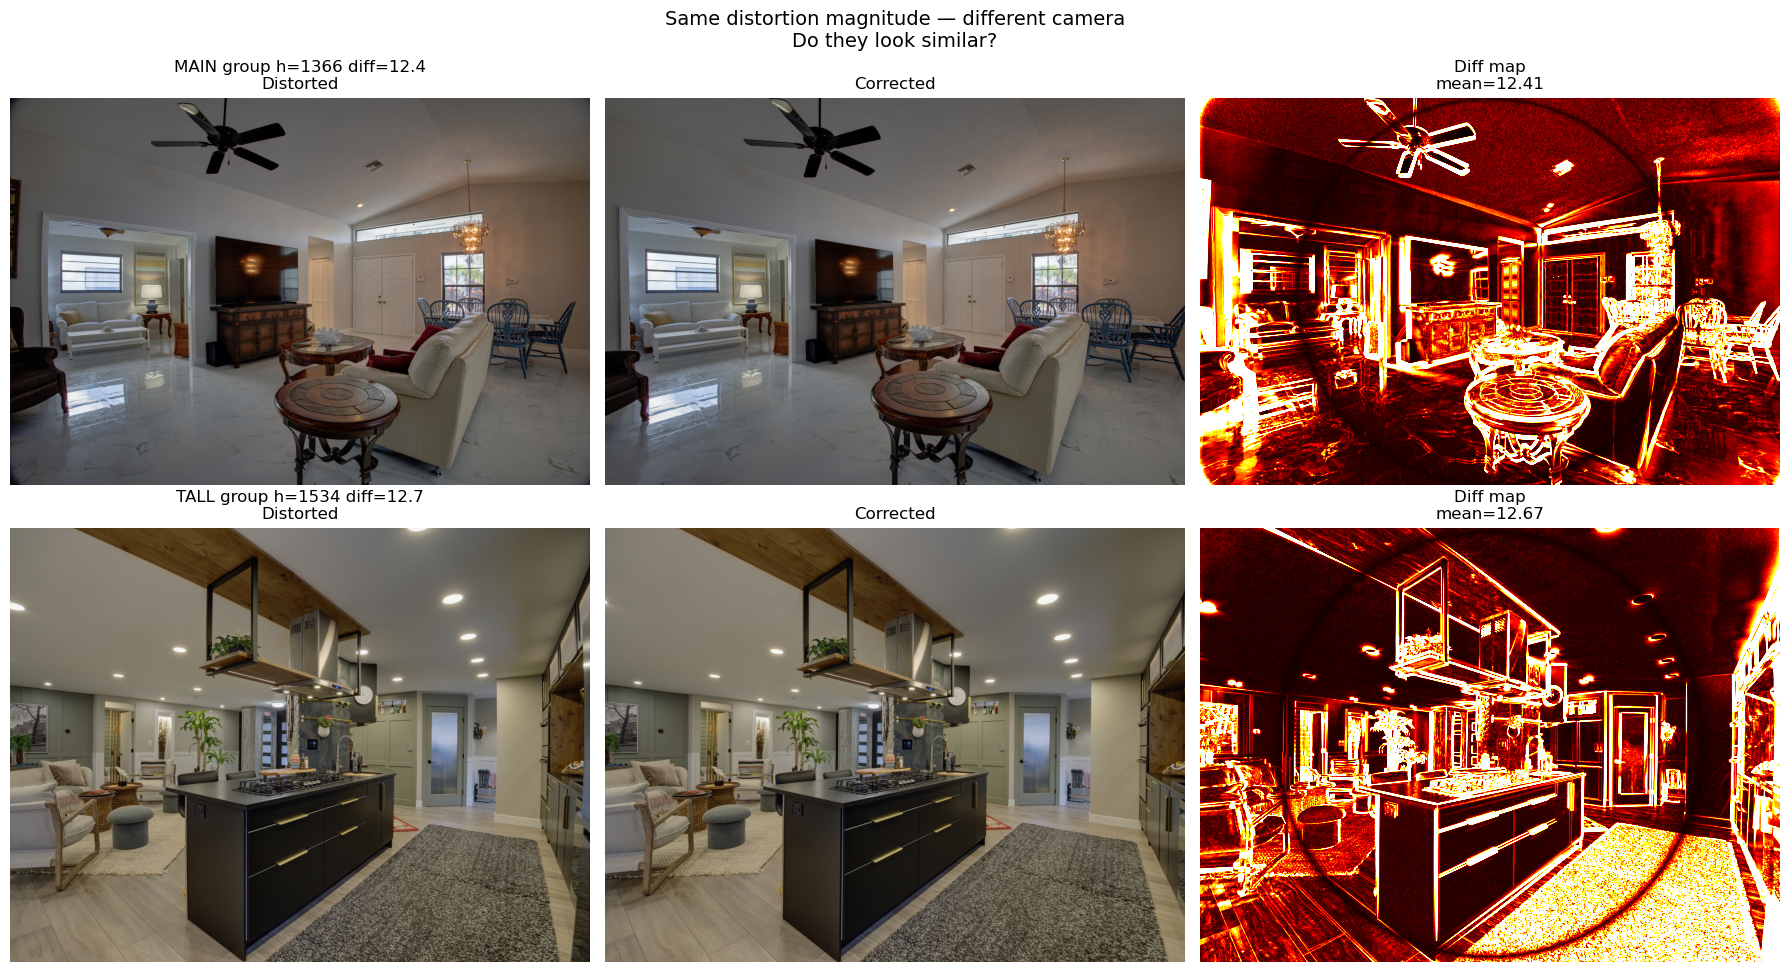

In [29]:
# Visual test: tall heavy vs main with similar diff — scan full dataset
tall_heavy = None
main_similar = None

for dist_p, corr_p in tqdm(zip(distorted_paths, corrected_paths)):
    dist = cv2.imread(str(dist_p))
    corr = cv2.imread(str(corr_p))
    if dist is None or corr is None:
        continue
    h, w = dist.shape[:2]
    if h > w:
        dist = cv2.rotate(dist, cv2.ROTATE_90_CLOCKWISE)
        corr = cv2.rotate(corr, cv2.ROTATE_90_CLOCKWISE)
        h, w = dist.shape[:2]
    diff = cv2.absdiff(dist, corr).mean()

    if h > 1380 and diff > 10:
        tall_heavy = (dist_p, corr_p, dist.copy(), corr.copy(), diff, h)

    if 1342 <= h <= 1380 and 12 < diff < 16:
        main_similar = (dist_p, corr_p, dist.copy(), corr.copy(), diff, h)

    if tall_heavy and main_similar:
        break

if tall_heavy and main_similar:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    for row_idx, (dist_p, corr_p, dist, corr, diff, h) in enumerate([main_similar, tall_heavy]):
        label = f"MAIN group h={h} diff={diff:.1f}" if row_idx == 0 else f"TALL group h={h} diff={diff:.1f}"
        diff_map = cv2.absdiff(dist, corr).mean(axis=2)

        axes[row_idx, 0].imshow(cv2.cvtColor(dist, cv2.COLOR_BGR2RGB))
        axes[row_idx, 0].set_title(f"{label}\nDistorted")
        axes[row_idx, 0].axis("off")

        axes[row_idx, 1].imshow(cv2.cvtColor(corr, cv2.COLOR_BGR2RGB))
        axes[row_idx, 1].set_title("Corrected")
        axes[row_idx, 1].axis("off")

        axes[row_idx, 2].imshow(diff_map, cmap="hot", vmin=0, vmax=30)
        axes[row_idx, 2].set_title(f"Diff map\nmean={diff:.2f}")
        axes[row_idx, 2].axis("off")

    plt.suptitle("Same distortion magnitude — different camera\nDo they look similar?", fontsize=14)
    plt.tight_layout()
    plt.savefig("tall_vs_main_comparison.png", dpi=150)
    plt.show()
else:
    print("Could not find both tall_heavy and main_similar — try relaxing criteria")


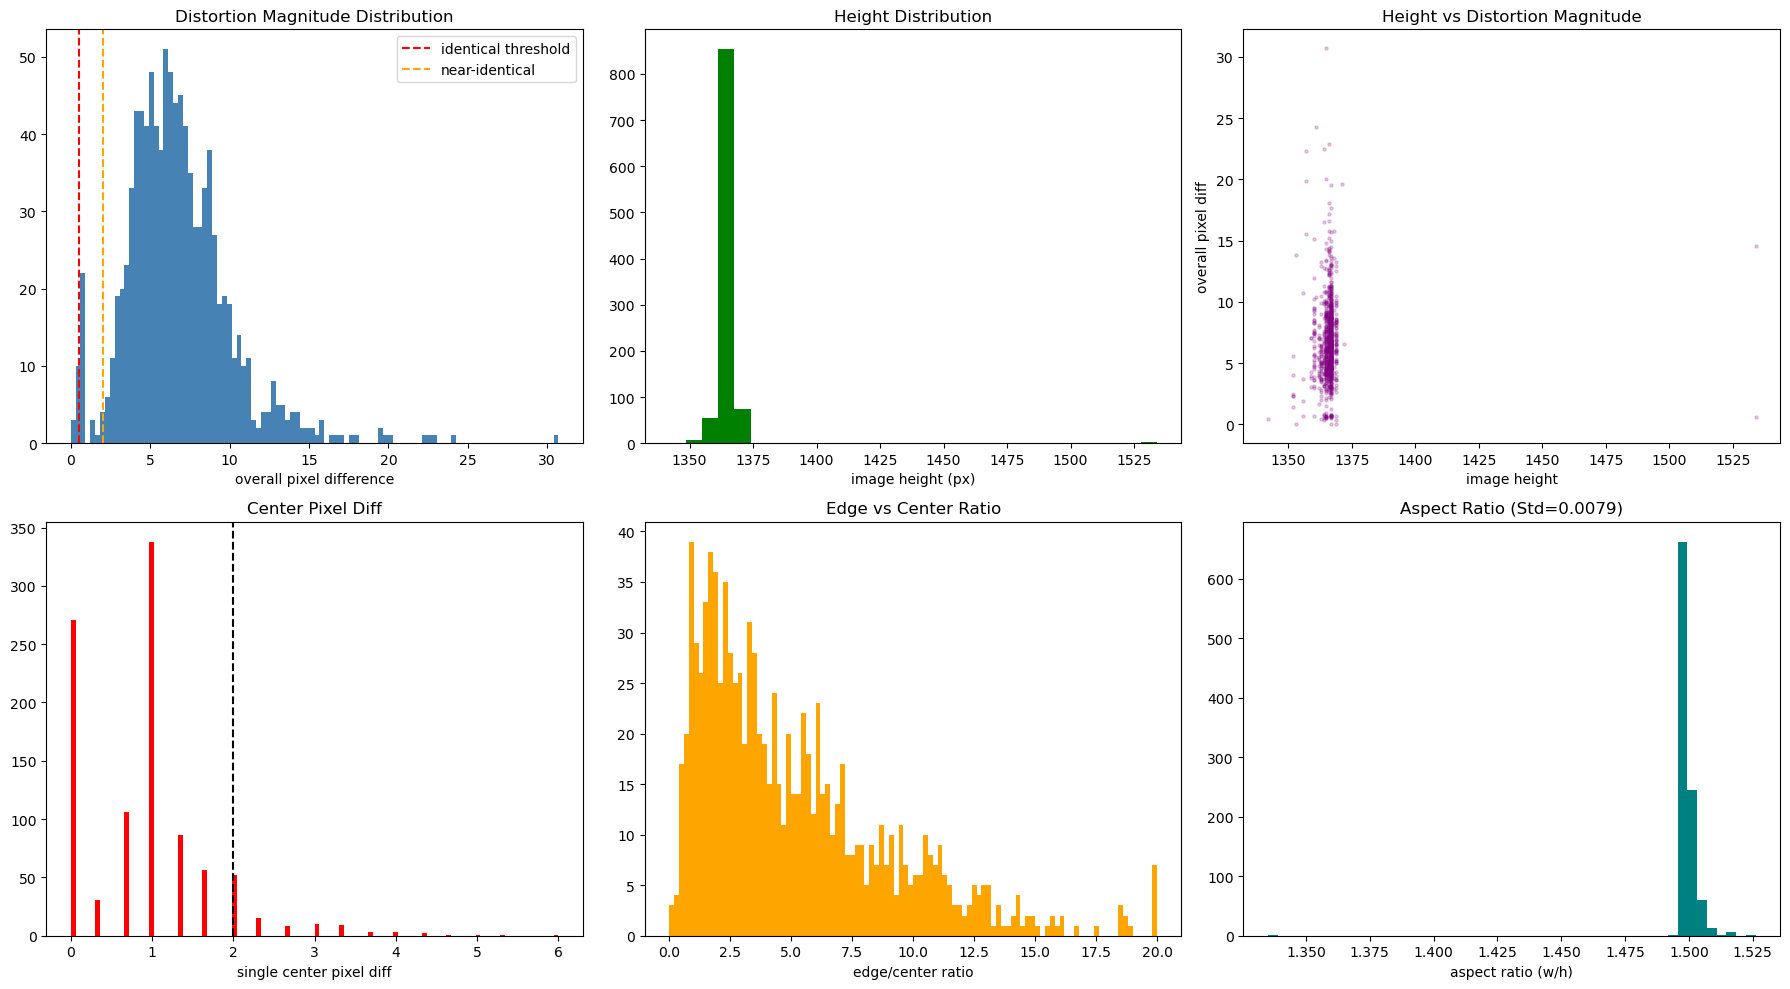


DATA CLEANING PLAN:
  Total images:              994
  Identical (diff<0.5):      7  ← REMOVE
  Near-identical (diff<2.0): 40  ← CONSIDER REMOVING
  Normal (diff≥2.0):         954 ← KEEP
  Heavy (diff>20):           6   ← KEEP, VALUABLE


In [24]:
# Visualize full population + data cleaning summary
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].hist(df_verify["overall_diff"], bins=100, edgecolor="none", color="steelblue")
axes[0, 0].axvline(x=0.5, color="red", linestyle="--", label="identical threshold")
axes[0, 0].axvline(x=2.0, color="orange", linestyle="--", label="near-identical")
axes[0, 0].set_xlabel("overall pixel difference")
axes[0, 0].set_title("Distortion Magnitude Distribution")
axes[0, 0].legend()

axes[0, 1].hist(df_verify["height"], bins=30, edgecolor="none", color="green")
axes[0, 1].set_xlabel("image height (px)")
axes[0, 1].set_title("Height Distribution")

axes[0, 2].scatter(df_verify["height"], df_verify["overall_diff"], alpha=0.2, s=5, color="purple")
axes[0, 2].set_xlabel("image height")
axes[0, 2].set_ylabel("overall pixel diff")
axes[0, 2].set_title("Height vs Distortion Magnitude")

axes[1, 0].hist(df_verify["single_px"], bins=100, edgecolor="none", color="red")
axes[1, 0].axvline(x=2.0, color="black", linestyle="--")
axes[1, 0].set_xlabel("single center pixel diff")
axes[1, 0].set_title("Center Pixel Diff")

axes[1, 1].hist(df_verify["edge_ratio"].clip(0, 20), bins=100, edgecolor="none", color="orange")
axes[1, 1].set_xlabel("edge/center ratio")
axes[1, 1].set_title("Edge vs Center Ratio")

axes[1, 2].hist(df_verify["aspect_ratio"], bins=50, edgecolor="none", color="teal")
axes[1, 2].set_xlabel("aspect ratio (w/h)")
axes[1, 2].set_title(f"Aspect Ratio (Std={df_verify['aspect_ratio'].std():.4f})")

plt.tight_layout()
plt.savefig("full_analysis.png", dpi=150)
plt.show()

print("\nDATA CLEANING PLAN:")
print(f"  Total images:              {len(df_verify)}")
print(f"  Identical (diff<0.5):      {(df_verify['overall_diff'] < 0.5).sum()}  ← REMOVE")
print(f"  Near-identical (diff<2.0): {(df_verify['overall_diff'] < 2.0).sum()}  ← CONSIDER REMOVING")
print(f"  Normal (diff≥2.0):         {(df_verify['overall_diff'] >= 2.0).sum()} ← KEEP")
print(f"  Heavy (diff>20):           {(df_verify['overall_diff'] > 20).sum()}   ← KEEP, VALUABLE")